# Load libraries

In [504]:
%matplotlib inline

import os
import math

import configparser

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

import sys
sys.path.append('../..')

from scripps.utils import read_datasets, norm1d, bayesian_linear_regression

import seaborn as sns

In [505]:
include_NER = False

In [506]:
CF = read_datasets.get_configuration()
cs_annotator_names = [key for key in dict(CF.items('m2c_citizen_disease')).keys() if key!='path']
cs_annotator_names.sort()
annotator_names = cs_annotator_names 
if include_NER:
    annotator_names = annotator_names + ['NER_expert']

In [507]:
all_labels = ['Disease', 'Phenotype', 'Both', 'None']

# Load "expert" annotations

In [508]:
def read_expert_disease_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_expert_disease', 'file')
    anno = anno[[0, 2]]
    anno[2].replace(['I-Disease', 'O', 'B-Disease', 'U-Disease', 'L-Disease'], [1, 0, 1, 1, 1], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[2].rename('NER_expert')], axis=1)
    return annotations

def read_expert_phenotype_annotations():
    annotations = pd.DataFrame()
    anno = read_datasets.load_dataset('m2c_expert_phenotype', 'file')
    anno = anno[[0, 2]]
    anno[2].replace(['I-phenotype', 'O', 'B-phenotype', 'L-phenotype', 'U-phenotype'], [1, 0, 1, 1, 1], inplace=True)
    annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
    annotations = pd.concat([annotations, anno[2].rename('NER_expert')], axis=1)
    return annotations

def read_expert_mixed_annotations(disease_annotations, phenotype_annotations):
    mixed = [disease_annotations['NER_expert'] == 1][0].replace([True, False], [1, 0]) + \
    [phenotype_annotations['NER_expert'] == 1][0].replace([True, False], [2, 0])
    mixed_annotations = pd.DataFrame()
    mixed_annotations = pd.concat([mixed_annotations, disease_annotations['Token']], axis=1)
    mixed_annotations = pd.concat([mixed_annotations, mixed.replace([0, 1, 2, 3], ['O', 'I-Disease', 'I-Phenotype', 'I-Disease_Pheno'])], axis=1)
    return mixed_annotations
    

In [509]:
expert_disease_annotations = read_expert_disease_annotations()
expert_phenotype_annotations = read_expert_phenotype_annotations()
expert_annotations = read_expert_mixed_annotations(expert_disease_annotations, expert_phenotype_annotations)

# Load all mark2cure citizen scientist annotations

In [510]:
CF = read_datasets.get_configuration()

def read_disease_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c_citizen_disease', anno_name)
        anno[3].replace(['I-Disease', 'O'], [1, 0], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

def read_phenotype_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c_citizen_phenotype', anno_name)
        anno[3].replace(['I-Phenotype', 'O'], [1, 0], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

# Load original annotations

In [511]:
def read_both_annotations():
    annotations = pd.DataFrame()
    idx = 0
    for anno_name in cs_annotator_names:
        anno = read_datasets.load_dataset('m2c', anno_name)
        anno[3].replace(['I-?', 'I-Disease_Phen', 'I-Gene'], ['O', 'I-Disease_Pheno', 'O'], inplace=True)
        anno[3].replace(['I-Disease', 'I-Phenotype', 'I-Disease_Pheno', 'O'], \
                        ['Disease', 'Phenotype', 'Both', 'None'], inplace=True)
        if idx == 0:
            annotations = pd.concat([annotations, anno[0].rename('Token')], axis=1)
            idx += 1
        annotations = pd.concat([annotations, anno[3].rename(anno_name)], axis=1)
    return annotations

def sanity_check(annotations, columns, values):
    for col in columns:
        assert set(annotations[col].unique()) == set(values)


In [512]:
disease_annotations = read_disease_annotations()
phenotype_annotations = read_phenotype_annotations()

In [513]:
mixed_annotations = read_both_annotations()
sanity_check(mixed_annotations, cs_annotator_names, all_labels)

In [514]:
if include_NER:
    mixed_annotations = pd.concat([mixed_annotations, expert_annotations['NER_expert']], axis=1)
    disease_annotations = pd.concat([disease_annotations, expert_disease_annotations['NER_expert']], axis=1)
    phenotype_annotations = pd.concat([phenotype_annotations, expert_phenotype_annotations['NER_expert']], axis=1)

In [515]:
mixed_annotations

,Token,m2c1,m2c2,m2c3,m2c5,m2c6_1st,m2c6_2nd
0,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both
1,and,None,None,None,None,None,None
2,abdominal,Disease,Disease,Disease,Both,Disease,Disease
3,aortic,Disease,Disease,Disease,Both,Disease,Disease
4,aneurysm,Disease,Disease,Disease,Both,Disease,Disease
5,.,None,None,None,None,None,None
6,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both
7,and,None,None,None,None,None,None
8,left,Phenotype,Phenotype,None,None,Both,Phenotype
9,loin,Phenotype,Phenotype,None,Phenotype,Both,Phenotype


# Filter relevant rows

In [516]:
def get_relevant_rows(annotations):
    relevant = annotations[annotator_names] != 'None'
    relevant = annotations[relevant.all(axis=1)]
    #relevant = annotations[~(annotations[['Annotator1', 'Annotator2', 'Annotator3', 'Annotator4', 'Annotator5']] == 'O').all(axis=1)]
    return relevant

In [517]:
relevant_annotations = get_relevant_rows(mixed_annotations)

In [518]:
disease_annotations = disease_annotations.iloc[relevant_annotations.index]
phenotype_annotations = phenotype_annotations.iloc[relevant_annotations.index]

In [519]:
#disease_annotations = disease_annotations.reset_index()
#phenotype_annotations = phenotype_annotations.reset_index()

# Initialize latent variables

In [520]:
K = disease_annotations.shape[0]
J = disease_annotations.shape[1] - 1

latent = {}

latent['theta'] = np.zeros(K)
latent['d_alpha'] = np.zeros(J)
latent['d_beta'] = np.zeros(J)
latent['d_z'] = np.zeros((K, J))

latent['p_alpha'] = np.zeros(J)
latent['p_beta'] = np.zeros(J)
latent['p_z'] = np.zeros((K, J))

#Should these be separate for disease and phenotype?
latent['b0'] = np.zeros(2)
latent['B0_scale'] = 1
latent['m0'] = np.zeros(K) #TODO: ask HS regarding changing certain values here.
latent['C0_scale'] = 1

latent['K'] = K
latent['J'] = J

# Define functions for resampling using Gibbs sampling

In [521]:
def __get_alpha_beta_z(mode):
    if mode == 'disease':
        alpha = latent['d_alpha']
        beta = latent['d_beta']
        z = latent['d_z']
    else:
        alpha = latent['p_alpha']
        beta = latent['p_beta']
        z = latent['p_z']
    return alpha, beta, z
    

In [522]:
def __resample_z(alpha, beta, z, annotations):
    interval = [-100, 100] #Should this be changed?
    for k in range(K):
    #for k in annotations.index:
        for j in range(J):
            mean = alpha[j] + beta[j]*latent['theta'][k]
            std_dev = 1
            '''
            if(annotations['Annotator{}'.format(j+1)][k] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations['Annotator{}'.format(j+1)][k] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
            '''
            if(annotations[annotator_names[j]][annotations.index[k]] == 0):
                z[k, j] = norm1d.truncnormal(mean, std_dev, interval[0], 0)
            elif(annotations[annotator_names[j]][annotations.index[k]] == 1):
                z[k, j] = norm1d.truncnormal(mean, std_dev, 0, interval[1])
    
def resample_z(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    if mode == 'disease':
        annotations = disease_annotations
    else:
        annotations = phenotype_annotations
    __resample_z(alpha, beta, z, annotations)

In [523]:
def __resample_alpha_beta(alpha, beta, z):
    for j in range(J):
        Y = z[:, j]
        X = np.vstack((np.ones(K), latent['theta'])).T
        
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['b0'], latent['B0_scale'], 1)
        sample = np.random.multivariate_normal(WN, VN)
        alpha[j] = sample[0]
        beta[j] = sample[1]

def resample_alpha_beta(mode):
    alpha, beta, z = __get_alpha_beta_z(mode)
    __resample_alpha_beta(alpha, beta, z)

In [524]:
def resample_theta():
    for k in range(K):
        #Y = latent['d_z'][k, :] - latent['d_alpha'] + latent['p_z'][k, :] - latent['p_alpha']
        #X = latent['d_beta'] + latent['p_beta']
        Y = np.concatenate(((latent['d_z'][k, :] - latent['d_alpha']), (latent['p_z'][k, :] - latent['p_alpha'])), axis=0)
        X = np.concatenate((latent['d_beta'], latent['p_beta']), axis=0)
        X = np.reshape(X, (-1, 1))
        WN, VN = bayesian_linear_regression.linreg_post(X, Y, latent['m0'][k], latent['C0_scale'], 1)
        latent['theta'][k] = np.random.normal(WN, math.sqrt(VN))

In [525]:
def save_latent_variables():
    #TODO: save to csv.
    pass


def resample():
    resample_z('disease')
    resample_z('phenotype')
    resample_theta()
    resample_alpha_beta('disease')
    resample_alpha_beta('phenotype')
    
    save_latent_variables()
    
def has_converged():
    #TODO
    pass
    
def run_sampling(num_iter, thresh, print_freq=50):
    thetas = []
    d_alphas = []
    d_betas = []
    p_alphas = []
    p_betas = []
    for it in xrange(1, num_iter+1):
        resample()
        if it%print_freq == 0:
            print 'Iter {}/{} done.'.format(it, num_iter)
        if has_converged():
            break
        if it > thresh:
            thetas.append(np.array(latent['theta']))
            d_alphas.append(np.array(latent['d_alpha']))
            p_alphas.append(np.array(latent['p_alpha']))
            d_betas.append(np.array(latent['d_beta']))
            p_betas.append(np.array(latent['p_beta']))

    all_values = {}
    all_values['thetas'] = thetas
    all_values['d_alphas'] = d_alphas
    all_values['d_betas'] = d_betas
    all_values['p_alphas'] = p_alphas
    all_values['p_betas'] = p_betas
    
    return all_values

def get_averages(all_values, num_iter, thresh):
    avg_values = {}
    avg_values['theta'] = np.sum(all_values['thetas'], axis=0)/(num_iter - thresh)
    avg_values['d_alpha'] = np.sum(all_values['d_alphas'], axis=0)/(num_iter - thresh)
    avg_values['d_beta'] = np.sum(all_values['d_betas'], axis=0)/(num_iter - thresh)
    avg_values['p_alpha'] = np.sum(all_values['p_alphas'], axis=0)/(num_iter - thresh)
    avg_values['p_beta'] = np.sum(all_values['p_betas'], axis=0)/(num_iter - thresh)
    return avg_values

In [526]:
np.random.seed(23)
num_iter = 2000
thresh = 300
all_values = run_sampling(num_iter, thresh)
avg_values = get_averages(all_values, num_iter, thresh)

Iter 50/2000 done.
Iter 100/2000 done.
Iter 150/2000 done.
Iter 200/2000 done.
Iter 250/2000 done.
Iter 300/2000 done.
Iter 350/2000 done.
Iter 400/2000 done.
Iter 450/2000 done.
Iter 500/2000 done.
Iter 550/2000 done.
Iter 600/2000 done.
Iter 650/2000 done.
Iter 700/2000 done.
Iter 750/2000 done.
Iter 800/2000 done.
Iter 850/2000 done.
Iter 900/2000 done.
Iter 950/2000 done.
Iter 1000/2000 done.
Iter 1050/2000 done.
Iter 1100/2000 done.
Iter 1150/2000 done.
Iter 1200/2000 done.
Iter 1250/2000 done.
Iter 1300/2000 done.
Iter 1350/2000 done.
Iter 1400/2000 done.
Iter 1450/2000 done.
Iter 1500/2000 done.
Iter 1550/2000 done.
Iter 1600/2000 done.
Iter 1650/2000 done.
Iter 1700/2000 done.
Iter 1750/2000 done.
Iter 1800/2000 done.
Iter 1850/2000 done.
Iter 1900/2000 done.
Iter 1950/2000 done.
Iter 2000/2000 done.


In [527]:
def get_annotator_bias(alpha, beta):
    # compute xr and xa using above latent vars.
    xa = -(4*alpha - beta*beta)/(4*beta)
    xr = -(4*alpha + beta*beta)/(4*beta)
    return xa, xr

def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", hue=annotator, \
                         data=pos_annos, hue_order=['I-Disease', 'I-Disease_Pheno', 'I-Phenotype'])
    


In [528]:
theta_min = min(avg_values['theta'])
theta_max = max(avg_values['theta'])
print 'theta range: ({}, {})'.format(theta_min, theta_max)

theta range: (-2.48968461976, 1.3384104652)


In [529]:
relevant_annotations = relevant_annotations.reset_index()

In [530]:
pos = pd.DataFrame()
pos = pd.concat([pos, relevant_annotations[['Token'] + annotator_names]])
pos = pd.concat([pos, pd.Series(avg_values['theta']).rename('theta')], axis=1)
pos

,Token,m2c1,m2c2,m2c3,m2c5,m2c6_1st,m2c6_2nd,theta
0,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both,-1.462312
1,abdominal,Disease,Disease,Disease,Both,Disease,Disease,0.444595
2,aortic,Disease,Disease,Disease,Both,Disease,Disease,0.387158
3,aneurysm,Disease,Disease,Disease,Both,Disease,Disease,0.401549
4,Haematuria,Phenotype,Phenotype,Both,Phenotype,Both,Both,-1.483285
5,pain,Phenotype,Phenotype,Both,Phenotype,Both,Phenotype,-1.636094
6,abdominal,Disease,Disease,Disease,Both,Disease,Disease,0.386588
7,aortic,Disease,Disease,Disease,Both,Disease,Disease,0.456604
8,Acanthosis,Disease,Both,Both,Both,Disease,Disease,-0.275050
9,nigricans,Disease,Both,Both,Both,Disease,Disease,-0.252641


In [774]:
def plot_thetas(pos_annos, annotator):
    pos_annos['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", hue=annotator, data=pos_annos, \
                         hue_order=['Disease', 'Both', 'Phenotype'], \
                         palette={'Disease':'green', 'Phenotype':'red', 'Both':'blue'}, s=75)
    ax.get_yaxis().set_visible(False)
    ax.set_title(annotator + ' labels')
    ax.arrow(-2.6, 0, 4.1, 0, head_width=0.00006, head_length=0.00002, width=0.000002, fc='brown', ec='brown') 
    ax.set_xlabel('Disease-Phenotype spectrum')

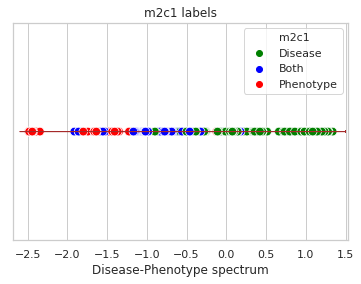

In [775]:
plot_thetas(pos, annotator_names[0])

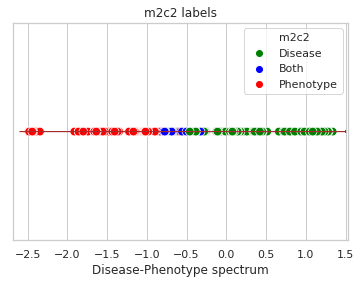

In [776]:
plot_thetas(pos, annotator_names[1])

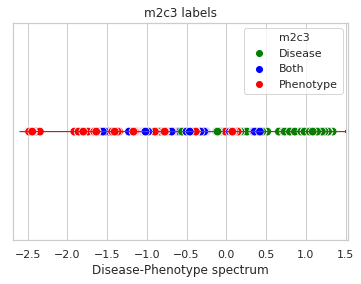

In [777]:
plot_thetas(pos, annotator_names[2])

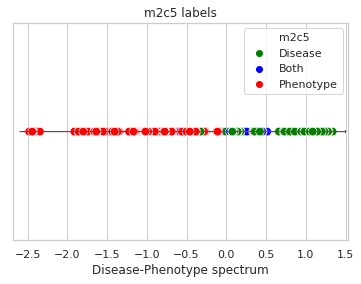

In [778]:
plot_thetas(pos, annotator_names[3])

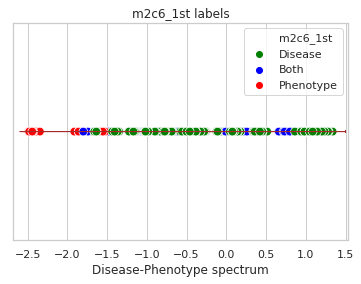

In [779]:
plot_thetas(pos, annotator_names[4])

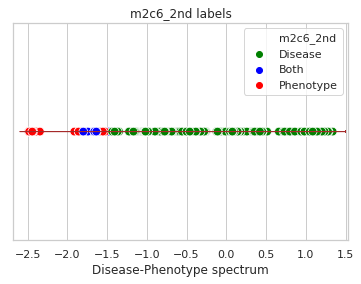

In [780]:
plot_thetas(pos, annotator_names[5])

In [537]:
xda, xdr = get_annotator_bias(avg_values['d_alpha'], avg_values['d_beta'])

In [538]:
xpa, xpr = get_annotator_bias(avg_values['p_alpha'], avg_values['p_beta'])

In [539]:
xda - xdr

array([0.72604297, 1.52892037, 0.56920849, 1.18661648, 0.54415963,
       0.40161365])

In [540]:
xpa - xpr

array([-1.00109613, -1.16063194, -0.71610669, -0.69242473, -0.21942913,
       -0.53823354])

In [541]:
(xda + xdr)/2

array([-1.41474493, -0.72761072, -1.13197592, -0.49125149, -1.94129333,
       -2.13509497])

In [542]:
(xpa + xpr)/2

array([-0.54572247, -0.4915847 , -0.15684008,  0.25466829, -2.16676907,
       -1.55175686])

In [543]:
loc_pd = pd.DataFrame()
loc_pd['xda'] = xda
loc_pd['xdr'] = xdr
loc_pd['xpa'] = xpa
loc_pd['xpr'] = xpr
loc_pd['annotator'] = annotator_names

In [544]:
loc_pd

,xda,xdr,xpa,xpr,annotator
0,-1.051723,-1.777766,-1.046271,-0.045174,m2c1
1,0.036849,-1.492071,-1.071901,0.088731,m2c2
2,-0.847372,-1.416580,-0.514893,0.201213,m2c3
3,0.102057,-1.084560,-0.091544,0.600881,m2c5
4,-1.669214,-2.213373,-2.276484,-2.057055,m2c6_1st
5,-1.934288,-2.335902,-1.820874,-1.282640,m2c6_2nd


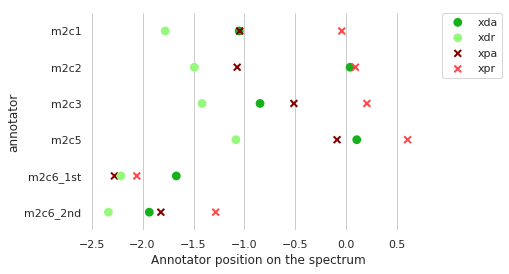

In [550]:
dis_pd = pd.DataFrame()
dis_pd['xda'] = xda
dis_pd['xdr'] = xdr
dis_pd['annotator'] = annotator_names

phe_pd = pd.DataFrame()
phe_pd['xpa'] = xpa
phe_pd['xpr'] = xpr
phe_pd['annotator'] = annotator_names
#'''

sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

#print(dis_pd)
#print
#print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1, ci=None, palette=sns.xkcd_palette(["green", "light green"]))

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1, ci=None, palette=sns.xkcd_palette(["dark red", "light red"]))

#ax.set_title('Annotator positions')
ax.set_xlabel('Annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [551]:
dis_loc = (xda + xdr)/2
phe_loc = (xpa + xpr)/2

phe_loc - dis_loc

array([ 0.86902247,  0.23602602,  0.97513585,  0.74591978, -0.22547575,
        0.58333812])

[1.37732894 0.6540563  1.75682551 0.84273227 1.83769606 2.48995519]


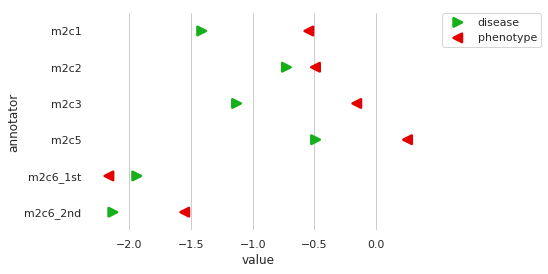

In [552]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc
dis_phe_pd['phenotype'] = phe_loc
dis_phe_pd['annotator'] = annotator_names

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

dis_phe_pd

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=[">", "<"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
#ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max), 0.5))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

dis_inverses = 1/(xda - xdr)
print(dis_inverses)

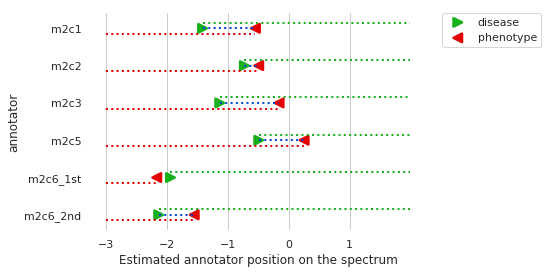

In [559]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc
dis_phe_pd['phenotype'] = phe_loc
dis_phe_pd['annotator'] = annotator_names

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

#print(dis_phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=[">", "<"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

i = 0
for annotator in annotator_names:
    #annotator = 'Annotator{}'.format(i+1)
    dis = dis_phe_pd[(dis_phe_pd['annotator'] == annotator) & (dis_phe_pd['measurement'] == 'disease')]['value']
    
    phe = dis_phe_pd[(dis_phe_pd['annotator'] == annotator) & (dis_phe_pd['measurement'] == 'phenotype')]['value']
    
    plt.plot([dis, np.ceil(theta_max)], [i-0.15, i-0.15], sns.xkcd_rgb["green"], lw=2, linestyle=':')
    plt.plot([np.floor(theta_min), phe], [i+0.15, i+0.15], sns.xkcd_rgb["red"], lw=2, linestyle=':')
    if dis.sum() < phe.sum():
        plt.plot([dis.sum(), phe.sum()], [i, i], sns.xkcd_rgb["blue"], lw=2, linestyle=':')
    i += 1

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max)))
ax.set_xlabel('Estimated annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Text(0,0.5,'Position instability estimate for disease')

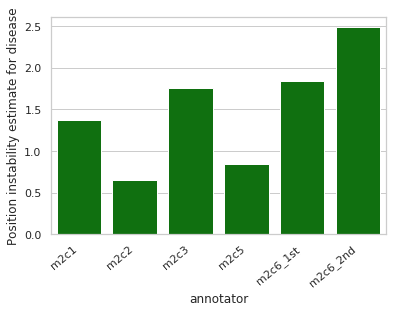

In [787]:
dis_inverses = 1/np.abs(xda - xdr)

dis_inverses_pd = pd.DataFrame()
dis_inverses_pd['error_bar'] = dis_inverses
dis_inverses_pd['annotator'] = annotator_names

ax = sns.barplot(x="annotator", y="error_bar", data=dis_inverses_pd, color="green")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_ylabel('Position instability estimate for disease')

Text(0,0.5,'Position instability estimate for phenotype')

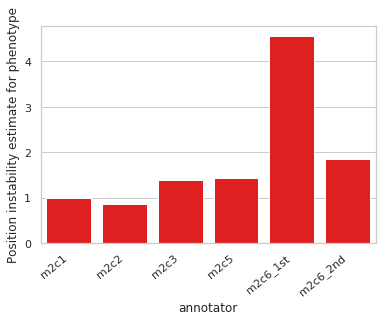

In [789]:
phe_inverses = 1/np.abs(xpr - xpa)

phe_inverses_pd = pd.DataFrame()
phe_inverses_pd['error_bar'] = phe_inverses
phe_inverses_pd['annotator'] = annotator_names

ax = sns.barplot(x="annotator", y="error_bar", data=phe_inverses_pd, color="red")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.set_ylabel('Position instability estimate for phenotype')

In [502]:
def plot_theta_tokens(pos_annos):
    pos_theta = pos[['Token', 'theta']]
    pos_theta['zeros'] = 0
    ax = sns.scatterplot(x="theta", y="zeros", data=pos_theta)

Text(0.5,0,'Disease-Phenotype spectrum')

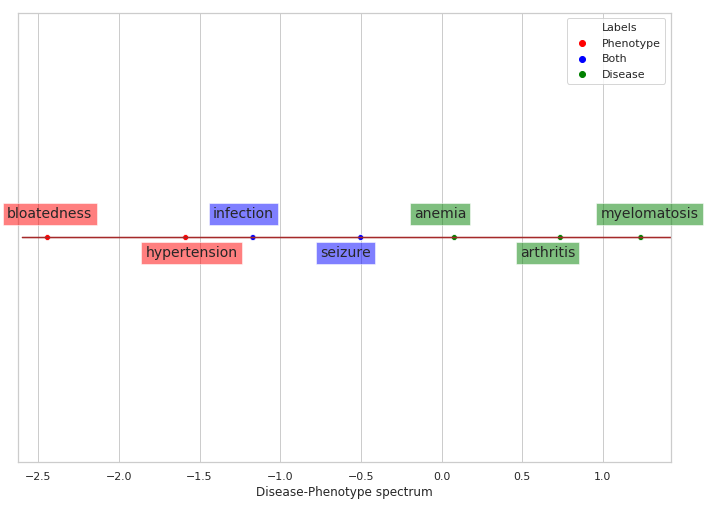

In [742]:
new_pos = pos[(pos['Token'] == 'bloatedness') | (pos['Token'] == 'seizure') | (pos['Token'] == 'infection') | (pos['Token'] == 'arthritis') | (pos['Token'] == 'hypertension') | (pos['Token'] == 'anemia') | (pos['Token'] == 'myelomatosis')].drop_duplicates(['Token'])
new_pos.sort_values('theta', inplace=True)
new_pos['Labels'] = ['Phenotype', 'Phenotype', 'Both', 'Both', 'Disease', 'Disease', 'Disease']

new_pos.reset_index()
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

palette={'Disease':'green', 'Phenotype':'red', 'Both':'blue'}
ax = sns.scatterplot(x="theta", y="zeros", data=new_pos, hue="Labels", \
                     palette=palette) #, \
                     #hue_order=['Disease', 'Both', 'Phenotype'])

ax.get_yaxis().set_visible(False)

mult = 1
pick = {'Disease':'green', 'Phenotype':'red', 'Both':'blue'}
for index, row in new_pos.iterrows():
    color = pick[row['Labels']]
    ax.text(row['theta']-0.25, 0.00007*mult, row['Token'], bbox = dict(facecolor=color, alpha=0.5), fontsize=14)
    mult *= -1
    
ax.arrow(-2.6, 0, 4.1, 0, head_width=0.00006, head_length=0.00002, width=0.000002, fc='brown', ec='brown') 
ax.set_xlabel('Disease-Phenotype spectrum')


In [741]:
new_pos

,Token,m2c1,m2c2,m2c3,m2c5,m2c6_1st,m2c6_2nd,theta,zeros,Labels
469,bloatedness,Phenotype,Phenotype,Phenotype,Phenotype,Phenotype,Phenotype,-2.443261,0,Phenotype
49,hypertension,Both,Phenotype,Both,Phenotype,Phenotype,Phenotype,-1.586480,0,Phenotype
462,infection,Both,Phenotype,Phenotype,Phenotype,Disease,Disease,-1.169111,0,Both
480,seizure,Disease,Both,Both,Phenotype,Disease,Disease,-0.501176,0,Both
451,anemia,Disease,Disease,Both,Both,Disease,Disease,0.079745,0,Both
162,arthritis,Disease,Disease,Disease,Disease,Both,Disease,0.736794,0,Disease
390,myelomatosis,Disease,Disease,Disease,Disease,Disease,Disease,1.236201,0,Disease


In [308]:
def count_relevant_stats(relevant_annotations, annotator, label):
    return relevant_annotations[relevant_annotations[annotator] == label][annotator].count()

In [309]:
def get_relevant_stats(relevant_annotations, annotator):
    print 'Statistics for {}'.format(annotator)
    print 'Percentage of Disease labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Disease')/503.0)
    print 'Percentage of Phenotype labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Phenotype')/503.0)
    print 'Percentage of both labels: {}'.format(count_relevant_stats(relevant_annotations, annotator, 'I-Disease_Pheno')/503.0)

In [259]:
for annotator in annotator_names:
    get_relevant_stats(relevant_annotations, annotator)
    print

Statistics for files1
Percentage of Disease labels: 0.628230616302
Percentage of Phenotype labels: 0.105367793241
Percentage of both labels: 0.157057654076

Statistics for files2
Percentage of Disease labels: 0.62226640159
Percentage of Phenotype labels: 0.20675944334
Percentage of both labels: 0.0616302186879

Statistics for files3
Percentage of Disease labels: 0.500994035785
Percentage of Phenotype labels: 0.165009940358
Percentage of both labels: 0.224652087475

Statistics for files4
Percentage of Disease labels: 0.375745526839
Percentage of Phenotype labels: 0.268389662028
Percentage of both labels: 0.246520874751

Statistics for files5
Percentage of Disease labels: 0.789264413519
Percentage of Phenotype labels: 0.0715705765408
Percentage of both labels: 0.0298210735586

Statistics for files6
Percentage of Disease labels: 0.729622266402
Percentage of Phenotype labels: 0.065606361829
Percentage of both labels: 0.0954274353877

Statistics for NER_expert
Percentage of Disease labels: 

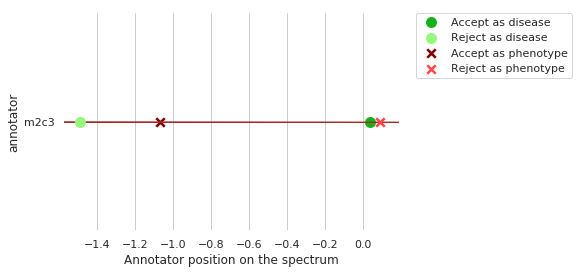

In [768]:
dis_pd = pd.DataFrame()
dis_pd['Accept as disease'] = xda[1:2]
dis_pd['Reject as disease'] = xdr[1:2]
dis_pd['annotator'] = ['m2c2']

phe_pd = pd.DataFrame()
phe_pd['Accept as phenotype'] = xpa[1:2]
phe_pd['Reject as phenotype'] = xpr[1:2]
phe_pd['annotator'] = ['m2c3']
#'''

sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

#print(dis_pd)
#print
#print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1.25, ci=None, palette=sns.xkcd_palette(["green", "light green"]))

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1.25, ci=None, palette=sns.xkcd_palette(["dark red", "light red"]))

#ax.set_title('Annotator positions')
ax.set_xlabel('Annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.arrow(-2.6, 0.002, 4.1, 0.002, fc='brown', ec='brown') 

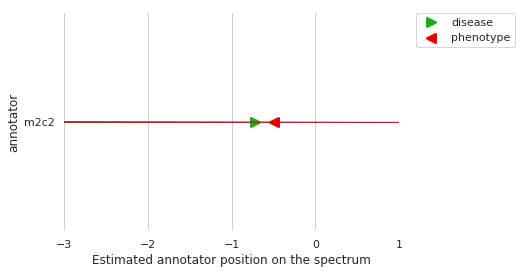

In [773]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc[1:2]
dis_phe_pd['phenotype'] = phe_loc[1:2]
dis_phe_pd['annotator'] = ['m2c2']

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

#print(dis_phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=[">", "<"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max)))
ax.set_xlabel('Estimated annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.arrow(-3.1, 0.002, 4.1, 0.002, fc='brown', ec='brown') 

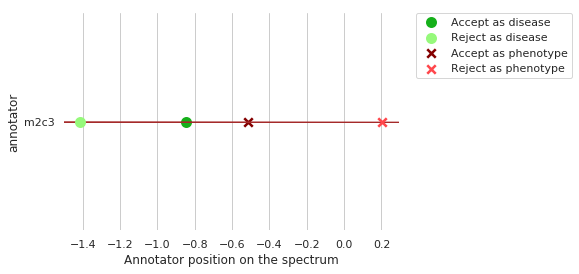

In [781]:
dis_pd = pd.DataFrame()
dis_pd['Accept as disease'] = xda[2:3]
dis_pd['Reject as disease'] = xdr[2:3]
dis_pd['annotator'] = ['m2c3']

phe_pd = pd.DataFrame()
phe_pd['Accept as phenotype'] = xpa[2:3]
phe_pd['Reject as phenotype'] = xpr[2:3]
phe_pd['annotator'] = ['m2c3']
#'''

sns.set(style="whitegrid")

dis_pd = pd.melt(dis_pd, "annotator", var_name="measurement")
phe_pd = pd.melt(phe_pd, "annotator", var_name="measurement")

#print(dis_pd)
#print
#print(phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_pd, dodge=0, join=False,
              markers="o", scale=1.25, ci=None, palette=sns.xkcd_palette(["green", "light green"]))

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=phe_pd, dodge=0, join=False,
              markers="x", scale=1.25, ci=None, palette=sns.xkcd_palette(["dark red", "light red"]))

#ax.set_title('Annotator positions')
ax.set_xlabel('Annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.arrow(-2.6, 0.002, 4.1, 0.002, fc='brown', ec='brown') 

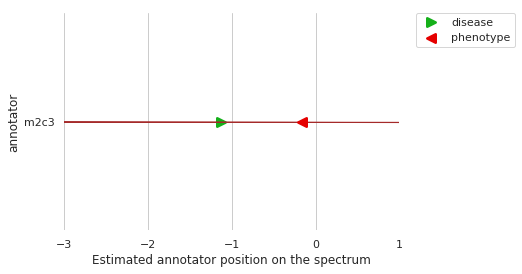

In [782]:
dis_phe_pd = pd.DataFrame()
dis_phe_pd['disease'] = dis_loc[2:3]
dis_phe_pd['phenotype'] = phe_loc[2:3]
dis_phe_pd['annotator'] = ['m2c3']

sns.set(style="whitegrid")

dis_phe_pd = pd.melt(dis_phe_pd, "annotator", var_name="measurement")

#print(dis_phe_pd)

f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

sns.pointplot(x="value", y="annotator", hue="measurement",
              data=dis_phe_pd, dodge=0, join=False,
              markers=[">", "<"], scale=1.25, ci=None, palette=sns.xkcd_palette(['green', 'red']))

#ax.set(xticks=[-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5])
ax.set(xticks=np.arange(np.floor(theta_min), np.ceil(theta_max)))
ax.set_xlabel('Estimated annotator position on the spectrum')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.arrow(-3.1, 0.002, 4.1, 0.002, fc='brown', ec='brown') 